### Support Vector Machine

In [1]:
import numpy as np
import scipy.io
import cvxopt
import cvxopt.solvers
import matplotlib.pyplot as plt

In [2]:
Syn1 = scipy.io.loadmat('synthetic1')
Syn2 = scipy.io.loadmat('synthetic2')

In [3]:
X_1 = Syn1['X']
X_2 = Syn2['X']
y_1 = Syn1['y']
y_2 = Syn2['y']

In [4]:
# functions of kernels
# linear kernel
def linear_kernel(x1,x2):
    return np.dot(x1,x2)

# gaussian kernel
def gaussian_kernel(x1,x2,sigma):
    return np.exp(-(np.linalg.norm(x1-x2))**2 / (2*(sigma**2)))

In [5]:
# function of getting kernel result
def kernel_result(x1,x2,kernel,kernel_par=0):
    if kernel==gaussian_kernel:
        return kernel(x1,x2,kernel_par)
    else:
        return kernel(x1,x2)

In [6]:
# function of training SVM
def svm_train(X,y,kernel_func,C,kernel_par=0):
    # number of observations and features
    n_obs,n_feas = np.shape(X)
    
    # set kernel function
    kernel = kernel_func
    sigma = kernel_par
    
    # compute kernel matrix of K(x_i,x_j)
    K = np.zeros((n_obs,n_obs))
    for i in range(n_obs):
        for j in range(n_obs):
            K[i,j] = kernel_result(X[i],X[j],kernel,sigma)
    
    # calculate matrices and vectors for cvxopt.qp
    P = cvxopt.matrix(np.outer(y,y) * K)
    q = cvxopt.matrix(np.ones(n_obs)*(-1))
    G_1 = np.identity(n_obs)*(-1)
    G_2 = np.identity(n_obs)
    G = cvxopt.matrix(np.vstack((G_1,G_2)))
    h_1 = np.zeros(n_obs)
    h_2 = np.ones(n_obs) * C
    h = cvxopt.matrix(np.hstack((h_1,h_2)))
    A = cvxopt.matrix(np.double(y),(1,n_obs))
    b = cvxopt.matrix(0.0)
    
    # solve the optimization
    solve_qp = cvxopt.solvers.qp(P, q, G, h, A, b)
    # obtain alpha vector
    alpha = np.array(solve_qp['x'])
    # index of support vectors (with alpha > 0)
    sv_index = np.where(alpha>1e-5)[0]
    # number of support vectors
    n_sv = np.shape(sv_index)[0]
    # alpha, x and y of support vectors
    alpha_sv = alpha[sv_index]
    X_sv = X[sv_index,:]
    y_sv = y[sv_index]
    
    print(np.shape(alpha_sv))
    
    # calculate w by support vectors
    w = np.dot(alpha_sv.T,(y_sv*X_sv))
    
    # calculate b by support vectors
    b = 0
    for i in range(n_sv):
        b += y_sv[i,0]
        b -= np.sum(alpha_sv*y_sv*K[sv_index[i],sv_index])
    b = b / n_sv
    
    # list of result
    model = [alpha_sv,w,b,X_sv,y_sv,kernel,sigma]
    
    return model

In [7]:
# function of predicting test set (without taking sign)
def svm_predict(model,X_test):
    # number of test observations
    n_test = np.shape(X_test)[0]
    
    # type of kernel and parameter
    kernel = model[5]
    sigma = model[6]
    
    # if linear kernel, use w*x+b
    if kernel==linear_kernel:
        w = model[1]
        b = model[2]
        #pred = np.sign((np.dot(w,X_test.T)+b).T)
        p = (np.dot(w,X_test.T)+b).T
    # else use general form
    else:
        alpha_sv = model[0]
        b = model[2]
        X_sv = model[3]
        y_sv = model[4]
        
        # number of support vectors
        n_sv = np.shape(y_sv)[0]
        # initiate prediction
        p = np.zeros(n_test)
        
        # for each test observation compute general form
        for i in range(n_test):
            p_i = 0
            X_i = X_test[i:i+1,:]
            # for each support vector
            for j in range(n_sv):
                p_i += alpha_sv[j] * y_sv[j] * kernel_result(X_i,X_sv[j],kernel,sigma)
            
            p[i] = p_i
        
        # add bias
        p += b
        # take sign and convert form
        #pred = np.sign(p)
        #pred = np.matrix(pred).T
        p = np.matrix(p).T
    
    return p

In [8]:
# function of predicting test set (taking sign)
def svm_predict_sign(model,X_test):
    p = svm_predict(model,X_test)
    pred = np.sign(p)
    
    return pred

In [9]:
# function of accuracy
def svm_accuracy(model,X_test,y_test):
    y_pred = svm_predict_sign(model,X_test)
    
    # number of correct predictions
    n_correct = np.sum(y_test==y_pred)
    # number of test observations
    n_test = np.shape(y_test)[0]
    
    return n_correct/n_test

In [10]:
# function of cross validation
# use 5-fold CV
def cross_validation(X,y,n_obs,kernel,C,sigma=0):
    # index of 5 folds
    indices = np.arange(n_obs)
    # initiate accuracy
    acc = 0
    
    # construct training and validation sets
    # do cross validation
    for i in range(5):
        # validation set i
        val_ind = np.r_[i:n_obs:5]
        train_ind = np.where(indices%5!=i)[0]
        X_val = X[val_ind,:]
        X_train = X[train_ind,:]
        y_val = y[val_ind,:]
        y_train = y[train_ind,:]
        
        # train model
        model = svm_train(X_train,y_train,kernel,C,sigma)
        acc_i = svm_accuracy(model,X_val,y_val)
        
        acc += acc_i/5
    
    return acc

In [11]:
# Dataset 1 Cross Validation with linear kernel
n_1 = np.shape(X_1)[0]
C_1_linear = 0.1
acc_1_linear = cross_validation(X_1,y_1,n_1,linear_kernel,C_1_linear)
acc_1_linear

     pcost       dcost       gap    pres   dres
 0: -8.7738e+01 -3.2918e+01  7e+02  2e+01  3e-15
 1: -1.2649e+01 -3.1634e+01  2e+01  7e-15  2e-15
 2: -1.4770e+01 -1.6094e+01  1e+00  2e-15  6e-16
 3: -1.5558e+01 -1.5721e+01  2e-01  7e-16  5e-16
 4: -1.5641e+01 -1.5666e+01  3e-02  6e-16  5e-16
 5: -1.5652e+01 -1.5663e+01  1e-02  4e-15  5e-16
 6: -1.5658e+01 -1.5661e+01  3e-03  3e-15  5e-16
 7: -1.5659e+01 -1.5660e+01  3e-05  1e-15  5e-16
 8: -1.5660e+01 -1.5660e+01  3e-07  7e-16  6e-16
Optimal solution found.
(160, 1)
     pcost       dcost       gap    pres   dres
 0: -8.6660e+01 -3.4218e+01  8e+02  2e+01  2e-15
 1: -1.2573e+01 -3.2890e+01  2e+01  1e-01  2e-15
 2: -1.3971e+01 -1.5832e+01  2e+00  8e-03  5e-16
 3: -1.4641e+01 -1.5210e+01  6e-01  2e-03  4e-16
 4: -1.4726e+01 -1.5198e+01  5e-01  2e-03  4e-16
 5: -1.4851e+01 -1.5156e+01  3e-01  4e-04  3e-16
 6: -1.4970e+01 -1.5055e+01  9e-02  9e-05  4e-16
 7: -1.5003e+01 -1.5024e+01  2e-02  2e-05  5e-16
 8: -1.5013e+01 -1.5015e+01  3e-03  2e

0.52

In [12]:
# Dataset 1 training with linear kernel
model_1_linear = svm_train(X_1,y_1,linear_kernel,0.1)
acc_1_linear = svm_accuracy(model_1_linear,X_1,y_1)
acc_1_linear

     pcost       dcost       gap    pres   dres
 0: -1.0946e+02 -4.1624e+01  9e+02  2e+01  3e-15
 1: -1.5697e+01 -4.0003e+01  2e+01  6e-15  3e-15
 2: -1.8290e+01 -2.0051e+01  2e+00  1e-15  7e-16
 3: -1.9098e+01 -1.9524e+01  4e-01  1e-15  5e-16
 4: -1.9149e+01 -1.9525e+01  4e-01  1e-15  4e-16
 5: -1.9226e+01 -1.9502e+01  3e-01  2e-15  4e-16
 6: -1.9304e+01 -1.9460e+01  2e-01  6e-16  4e-16
 7: -1.9351e+01 -1.9421e+01  7e-02  2e-15  5e-16
 8: -1.9383e+01 -1.9387e+01  4e-03  2e-15  6e-16
 9: -1.9385e+01 -1.9385e+01  5e-05  3e-15  7e-16
10: -1.9385e+01 -1.9385e+01  6e-07  2e-15  6e-16
Optimal solution found.
(198, 1)


0.535

In [13]:
# Dataset 2 Cross Validation with linear kernel
n_2 = np.shape(X_2)[0]
C_2_linear = 0.1
acc_2_linear = cross_validation(X_2,y_2,n_2,linear_kernel,C_2_linear)
acc_2_linear

     pcost       dcost       gap    pres   dres
 0: -1.7593e+02 -6.4652e+01  1e+03  2e+01  2e-15
 1: -2.5580e+01 -6.2122e+01  4e+01  2e-14  3e-15
 2: -2.9963e+01 -3.2361e+01  2e+00  2e-15  8e-16
 3: -3.1861e+01 -3.1963e+01  1e-01  6e-15  7e-16
 4: -3.1944e+01 -3.1945e+01  1e-03  1e-15  7e-16
 5: -3.1945e+01 -3.1945e+01  1e-05  4e-15  7e-16
Optimal solution found.
(320, 1)
     pcost       dcost       gap    pres   dres
 0: -1.7553e+02 -6.5732e+01  1e+03  2e+01  2e-15
 1: -2.5332e+01 -6.3169e+01  4e+01  3e-15  2e-15
 2: -2.9642e+01 -3.2281e+01  3e+00  4e-15  8e-16
 3: -3.1538e+01 -3.1707e+01  2e-01  2e-15  7e-16
 4: -3.1667e+01 -3.1672e+01  5e-03  4e-15  6e-16
 5: -3.1671e+01 -3.1671e+01  5e-05  1e-15  7e-16
 6: -3.1671e+01 -3.1671e+01  5e-07  9e-15  7e-16
Optimal solution found.
(320, 1)
     pcost       dcost       gap    pres   dres
 0: -1.7600e+02 -6.4149e+01  1e+03  2e+01  2e-15
 1: -2.5675e+01 -6.1632e+01  4e+01  2e-14  2e-15
 2: -3.0068e+01 -3.2318e+01  2e+00  3e-15  8e-16
 3: -3

0.52

In [14]:
# Dataset 2 training with linear kernel
model_2_linear = svm_train(X_2,y_2,linear_kernel,0.01)
acc_2_linear = svm_accuracy(model_2_linear,X_2,y_2)
acc_2_linear

     pcost       dcost       gap    pres   dres
 0: -2.0189e+02 -8.0926e+00  2e+03  4e+01  3e-15
 1: -4.8079e+00 -8.0606e+00  2e+01  4e-01  3e-15
 2: -3.3777e+00 -5.7715e+00  2e+00  6e-16  4e-16
 3: -3.9179e+00 -4.0203e+00  1e-01  3e-16  6e-16
 4: -3.9981e+00 -3.9991e+00  1e-03  2e-16  5e-16
 5: -3.9989e+00 -3.9989e+00  1e-05  2e-16  5e-16
 6: -3.9989e+00 -3.9989e+00  1e-07  9e-16  5e-16
Optimal solution found.
(400, 1)


0.515

In [15]:
# Dataset 1 Cross Validation with gaussian kernel 
C_1_gau = 7.5
sigma_1_gau = 0.3
acc_1_gau_cv = cross_validation(X_1,y_1,n_1,gaussian_kernel,C_1_gau,sigma_1_gau)
acc_1_gau_cv

     pcost       dcost       gap    pres   dres
 0:  2.8532e+02 -2.8095e+03  3e+03  6e-15  3e-15
 1:  3.1537e+01 -2.4839e+02  3e+02  1e-14  2e-15
 2: -2.3474e+01 -9.2779e+01  7e+01  1e-15  1e-15
 3: -3.5974e+01 -4.9797e+01  1e+01  2e-14  7e-16
 4: -3.8950e+01 -4.1960e+01  3e+00  4e-16  5e-16
 5: -3.9670e+01 -4.0368e+01  7e-01  1e-14  5e-16
 6: -3.9894e+01 -3.9989e+01  9e-02  3e-15  6e-16
 7: -3.9923e+01 -3.9936e+01  1e-02  2e-14  8e-16
 8: -3.9928e+01 -3.9928e+01  2e-04  2e-14  8e-16
 9: -3.9928e+01 -3.9928e+01  2e-06  2e-15  7e-16
Optimal solution found.
(54, 1)
     pcost       dcost       gap    pres   dres
 0:  2.8535e+02 -2.6441e+03  3e+03  7e-15  3e-15
 1:  3.4716e+01 -2.8157e+02  3e+02  9e-16  2e-15
 2: -2.0859e+01 -1.0628e+02  9e+01  2e-14  1e-15
 3: -3.4448e+01 -5.2742e+01  2e+01  4e-15  7e-16
 4: -3.7641e+01 -4.1323e+01  4e+00  7e-15  6e-16
 5: -3.8488e+01 -3.9297e+01  8e-01  3e-15  7e-16
 6: -3.8736e+01 -3.8907e+01  2e-01  9e-15  6e-16
 7: -3.8779e+01 -3.8802e+01  2e-02  1e-

0.98

In [16]:
# Dataset 1 training with gaussian kernel
model_1_gau = svm_train(X_1,y_1,gaussian_kernel,7.5,0.3)
acc_1_gau = svm_accuracy(model_1_gau,X_1,y_1)
acc_1_gau

     pcost       dcost       gap    pres   dres
 0:  3.1592e+02 -3.3393e+03  4e+03  3e-15  3e-15
 1:  2.9448e+01 -2.8990e+02  3e+02  1e-14  3e-15
 2: -2.7951e+01 -1.4666e+02  1e+02  9e-16  1e-15
 3: -4.9486e+01 -7.3434e+01  2e+01  7e-15  9e-16
 4: -5.5023e+01 -5.9299e+01  4e+00  2e-14  1e-15
 5: -5.6071e+01 -5.7184e+01  1e+00  2e-14  1e-15
 6: -5.6453e+01 -5.6553e+01  1e-01  4e-16  1e-15
 7: -5.6489e+01 -5.6498e+01  9e-03  2e-14  1e-15
 8: -5.6492e+01 -5.6493e+01  7e-04  3e-15  1e-15
 9: -5.6493e+01 -5.6493e+01  1e-05  7e-15  1e-15
Optimal solution found.
(60, 1)


0.99

In [17]:
# Dataset 2 Cross Validation with gaussian kernel 
C_2_gau = 13
sigma_2_gau = 0.4
acc_2_gau_cv = cross_validation(X_2,y_2,n_2,gaussian_kernel,C_2_gau,sigma_2_gau)
acc_2_gau_cv

     pcost       dcost       gap    pres   dres
 0:  3.9553e+02 -2.1616e+04  4e+04  3e-01  1e-14
 1:  5.2506e+02 -2.9283e+03  4e+03  2e-02  1e-14
 2: -4.1717e+01 -9.6436e+02  1e+03  3e-03  1e-14
 3: -2.3754e+02 -6.8403e+02  5e+02  1e-03  1e-14
 4: -3.4995e+02 -5.1582e+02  2e+02  4e-04  1e-14
 5: -4.0015e+02 -4.6478e+02  7e+01  1e-04  1e-14
 6: -4.2039e+02 -4.4133e+02  2e+01  1e-05  2e-14
 7: -4.2903e+02 -4.3057e+02  2e+00  2e-07  2e-14
 8: -4.2972e+02 -4.2979e+02  7e-02  7e-09  2e-14
 9: -4.2975e+02 -4.2975e+02  1e-03  1e-10  2e-14
10: -4.2975e+02 -4.2975e+02  1e-05  1e-12  2e-14
Optimal solution found.
(50, 1)
     pcost       dcost       gap    pres   dres
 0:  3.6787e+02 -2.1991e+04  4e+04  3e-01  1e-14
 1:  5.1859e+02 -2.8933e+03  4e+03  1e-02  1e-14
 2: -6.1942e+01 -9.1478e+02  9e+02  3e-03  1e-14
 3: -2.9271e+02 -6.0728e+02  3e+02  8e-04  1e-14
 4: -3.6887e+02 -5.2356e+02  2e+02  3e-04  2e-14
 5: -4.0710e+02 -4.8211e+02  8e+01  1e-04  1e-14
 6: -4.2936e+02 -4.5563e+02  3e+01  3e-

0.9675

In [18]:
# Dataset 2 training with gaussian kernel
model_2_gau = svm_train(X_2,y_2,gaussian_kernel,13,0.4)
acc_2_gau = svm_accuracy(model_2_gau,X_2,y_2)
acc_2_gau

     pcost       dcost       gap    pres   dres
 0:  3.7471e+02 -2.7732e+04  5e+04  3e-01  2e-14
 1:  6.0176e+02 -3.8461e+03  5e+03  2e-02  2e-14
 2: -5.9199e+01 -1.1869e+03  1e+03  3e-03  2e-14
 3: -2.8141e+02 -8.7662e+02  6e+02  1e-03  2e-14
 4: -4.1569e+02 -6.7803e+02  3e+02  5e-04  2e-14
 5: -4.7372e+02 -5.9117e+02  1e+02  2e-04  2e-14
 6: -5.0691e+02 -5.5076e+02  4e+01  4e-05  2e-14
 7: -5.2302e+02 -5.3000e+02  7e+00  3e-06  2e-14
 8: -5.2608e+02 -5.2635e+02  3e-01  3e-08  2e-14
 9: -5.2621e+02 -5.2621e+02  5e-03  5e-10  2e-14
10: -5.2621e+02 -5.2621e+02  5e-05  5e-12  2e-14
Optimal solution found.
(61, 1)


0.98

In [19]:
# function of compute decision boundary for linear kernel
def svm_boundary_linear(w,b,upper,lower):
    x1_range = np.r_[upper:lower:0.01]
    x2_range = (-w[0] * x1_range - b) / w[1]
    
    return x1_range,x2_range

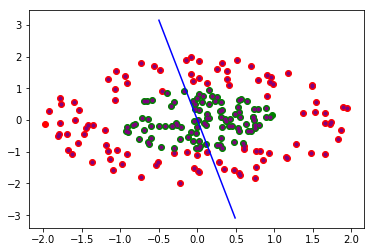

In [21]:
# plot dataset 1 with linear kernels
w_1_l = model_1_linear[1][0]
b_1_l = model_1_linear[2]
x1_1_l,x2_1_l = svm_boundary_linear(w_1_l,b_1_l,-0.5,0.5)
X_1_l_sv = model_1_linear[3]

positive_ind_1 = np.where(y_1==1)[0]
negative_ind_1 = np.where(y_1==-1)[0]
positive_X1 = X_1[positive_ind_1,:]
negative_X1 = X_1[negative_ind_1,:]

# with support vectors
plt.figure()
# plot dataset
plt.scatter(positive_X1[:,0],positive_X1[:,1],c="red")
plt.scatter(negative_X1[:,0],negative_X1[:,1],c="green")
# plot boundary
plt.plot(x1_1_l,x2_1_l,c="blue")
# plot support vectors
plt.scatter(X_1_l_sv[:,0],X_1_l_sv[:,1],c="purple",marker='.')
plt.show()

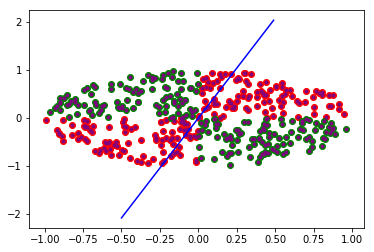

In [22]:
# plot dataset 2 with linear kernels
w_2_l = model_2_linear[1][0]
b_2_l = model_2_linear[2]
x1_2_l,x2_2_l = svm_boundary_linear(w_2_l,b_2_l,-0.5,0.5)
X_2_l_sv = model_2_linear[3]

positive_ind_2 = np.where(y_2==1)[0]
negative_ind_2 = np.where(y_2==-1)[0]
positive_X2 = X_2[positive_ind_2,:]
negative_X2 = X_2[negative_ind_2,:]

# with support vectors
plt.figure()
# plot dataset
plt.scatter(positive_X2[:,0],positive_X2[:,1],c="red")
plt.scatter(negative_X2[:,0],negative_X2[:,1],c="green")
# plot boundary
plt.plot(x1_2_l,x2_2_l,c="blue")
# plot support vectors
plt.scatter(X_2_l_sv[:,0],X_2_l_sv[:,1],c="purple",marker='.')
plt.show()

In [26]:
# function of computing decision boundary for gaussian kernel
def svm_boundary_gaussian(model,upper,lower,interval):
    x1_range = np.r_[upper:lower:interval]
    x2_range = np.r_[upper:lower:interval]
    x1_size = np.shape(x1_range)[0]
    x2_size = np.shape(x2_range)[0]
    y = np.zeros((x2_size,x1_size))
    
    for i in range(x1_size):
        for j in range(x2_size):
            x1 = x1_range[i]
            x2 = x2_range[j]
            x_test = np.array([[x1,x2]])
            p = svm_predict(model,x_test)
            y[j,i] = p
    
    return y

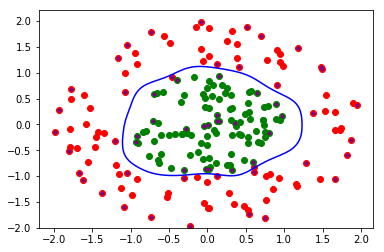

In [28]:
# plot dataset 1 with gaussian kernels
X_boundary_1 = np.r_[-2:2:0.05]
y_boundary_1 = svm_boundary_gaussian(model_1_gau,-2,2,0.05)
X_1_g_sv = model_1_gau[3]

positive_ind_1 = np.where(y_1==1)[0]
negative_ind_1 = np.where(y_1==-1)[0]
positive_X1 = X_1[positive_ind_1,:]
negative_X1 = X_1[negative_ind_1,:]

# with support vectors
plt.figure()
# plot dataset
plt.scatter(positive_X1[:,0],positive_X1[:,1],c="red")
plt.scatter(negative_X1[:,0],negative_X1[:,1],c="green")
# plot boundary
plt.contour(X_boundary_1,X_boundary_1,y_boundary_1,[0],colors="blue")
# plot support vectors
plt.scatter(X_1_g_sv[:,0],X_1_g_sv[:,1],c="purple",marker='.')
plt.show()

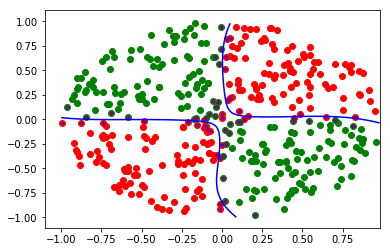

In [29]:
# plot dataset 2 with gaussian kernels
X_boundary_2 = np.r_[-1:1:0.02]
y_boundary_2 = svm_boundary_gaussian(model_2_gau,-1,1,0.02)
X_2_g_sv = model_2_gau[3]

positive_ind_2 = np.where(y_2==1)[0]
negative_ind_2 = np.where(y_2==-1)[0]
positive_X2 = X_2[positive_ind_2,:]
negative_X2 = X_2[negative_ind_2,:]

# with support vectors
plt.figure()
# plot dataset
plt.scatter(positive_X2[:,0],positive_X2[:,1],c="red")
plt.scatter(negative_X2[:,0],negative_X2[:,1],c="green")
# plot boundary
plt.contour(X_boundary_2,X_boundary_2,y_boundary_2,[0],colors="blue")
# plot support vectors
plt.scatter(X_2_g_sv[:,0],X_2_g_sv[:,1],c="purple",marker='.')
plt.show()